<a href="https://colab.research.google.com/github/Daudi232/DS_3/blob/main/Thesis/Segmentation/Segmentation_Custom_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Drive Config

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import kagglehub
import os
import pandas as pd
import PIL
from skimage import io

## Dataset Downloading

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamtapendu/chest-x-ray-lungs-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-x-ray-lungs-segmentation' dataset.
Path to dataset files: /kaggle/input/chest-x-ray-lungs-segmentation


### Structure of the dataset and exploration

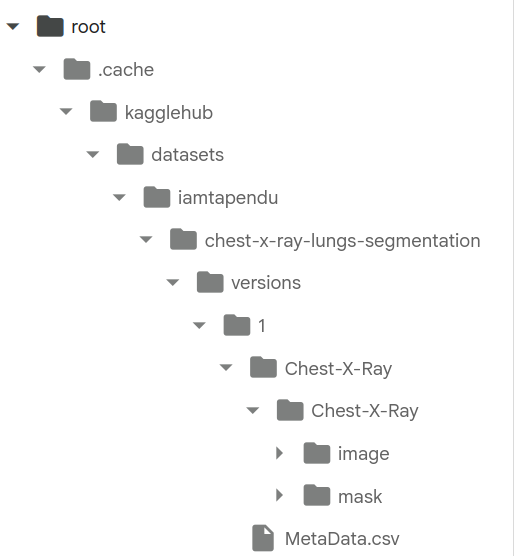

In [ ]:
import os
import pandas as pd

im_path = os.path.join(path, 'Chest-X-Ray', 'Chest-X-Ray', 'image')
mask_path = os.path.join(path, 'Chest-X-Ray', 'Chest-X-Ray', 'mask')
im_ls = os.listdir(im_path)
mask_ls = os.listdir(mask_path)

print(im_ls[:5])
print(mask_ls[:5])

print(len(im_ls))
print(len(mask_ls))

['1231.png', '1017.png', '1522.png', '1088.png', '1479.png']
['1231.png', '1017.png', '1522.png', '1088.png', '1479.png']
704
704


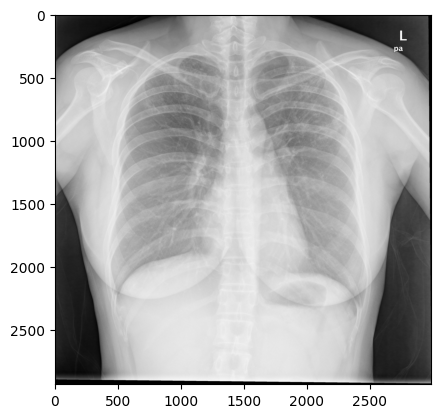

In [ ]:
import matplotlib.pyplot as plt

img = io.imread(os.path.join(im_path, im_ls[0]))

plt.imshow(img, cmap = 'gray');

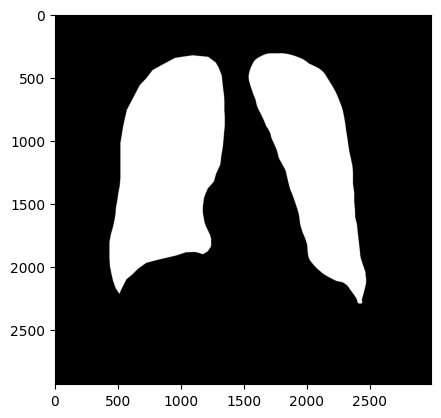

In [ ]:
import matplotlib.pyplot as plt

mask = io.imread(os.path.join(mask_path, mask_ls[0]))

plt.imshow(mask, cmap = 'gray');

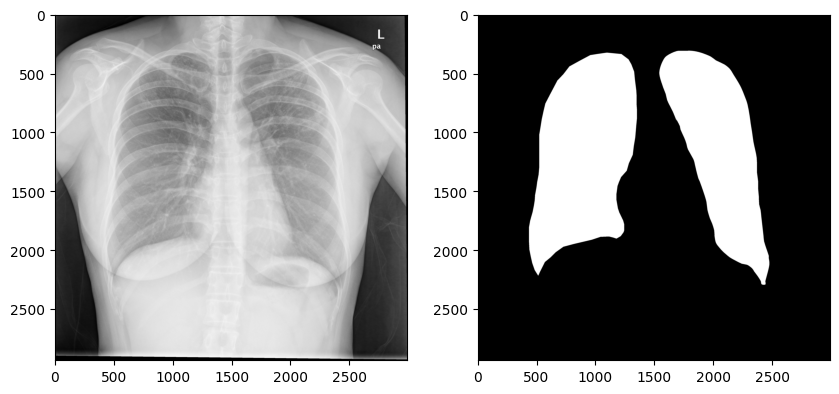

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].imshow(img, cmap = 'gray');
ax[1].imshow(mask, cmap = 'gray');

## Helper Functions

### Database setup

In [ ]:
def database_setup(root_dir):

  print('Creating folders')
  import os
  import shutil

  folders = ['train', 'test', 'val']
  subfolders = ['images', 'masks']

  for folder in folders:
    for subfolder in subfolders:
      if not os.path.exists(os.path.join(folder, subfolder)):
        os.makedirs(os.path.join(folder, subfolder))

  # Creates a list of images and masks, sorted in accordance to the dog/cat name
  im_path = os.path.join(root_dir, 'Chest-X-Ray', 'Chest-X-Ray', 'image')
  mask_path = os.path.join(root_dir, 'Chest-X-Ray', 'Chest-X-Ray', 'mask')

  im_dir_ls = os.listdir(im_path)
  mask_dir_ls = os.listdir(mask_path)

  im_ls = []
  mask_ls = []

  # the second condition is because of the hidden files
  for i in im_dir_ls:
    if i.endswith('png') and not i.startswith('.'):
      im_ls.append(i)

  for i in mask_dir_ls:
    if i.endswith('png') and not i.startswith('.'):
      mask_ls.append(i)

  print(f'Images found: {len(im_ls)}')
  print(f'Masks found: {len(mask_ls)}')

  # introduce randomness which is useful for splitting
  import random

  random.Random(7).shuffle(im_ls)
  random.Random(7).shuffle(mask_ls)

  # sort so that the image and mask match
  im_ls = sorted(im_ls)
  mask_ls = sorted(mask_ls)

  # visualize an image and it's mask
  from skimage import io
  import matplotlib.pyplot as plt

  img = io.imread(os.path.join(im_path, im_ls[0]))
  mask = io.imread(os.path.join(mask_path, mask_ls[0]))

  fig, ax = plt.subplots(1, 2, figsize = (10, 5))

  ax[0].imshow(img, cmap = 'gray');
  ax[1].imshow(mask, cmap = 'gray');
  ax[0].set_title('Image');
  ax[1].set_title('Mask');

  # Divide the dataset to their directories
  import shutil

  train_ratio = 0.8
  val_ratio = 0.1
  test_ratio = 0.1
  size = len(im_ls)

  train_size = int(size * train_ratio)
  val_size = int(size * val_ratio)
  test_size = int(size * test_ratio)

  train_im_ls = im_ls[:train_size]
  val_im_ls = im_ls[train_size: train_size + val_size + 1]
  test_im_ls = im_ls[train_size + val_size + 1:]

  train_mask_ls = mask_ls[:train_size]
  val_mask_ls = mask_ls[train_size:train_size + val_size + 1]
  test_mask_ls = mask_ls[train_size + val_size + 1:]

  print('Dividing dataset to directories')
  for img in train_im_ls:
    shutil.copy(os.path.join(im_path, img), os.path.join('train', 'images'))

  for mask in train_mask_ls:
    shutil.copy(os.path.join(mask_path, mask), os.path.join('train', 'masks'))

  for img in val_im_ls:
    shutil.copy(os.path.join(im_path, img), os.path.join('val', 'images'))

  for mask in val_mask_ls:
    shutil.copy(os.path.join(mask_path, mask), os.path.join('val', 'masks'))

  for img in test_im_ls:
    shutil.copy(os.path.join(im_path, img), os.path.join('test', 'images'))

  for mask in test_mask_ls:
    shutil.copy(os.path.join(mask_path, mask), os.path.join('test', 'masks'))

  print('Done')

  return im_ls, mask_ls

Creating folders
Images found: 704
Masks found: 704
Dividing dataset to directories
Done


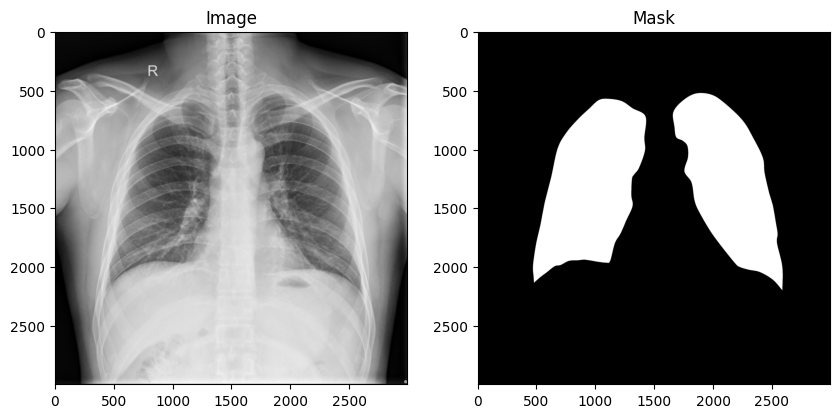

In [ ]:
im_ls, mask_ls = database_setup(path)

In [ ]:
# The dimensions and contents of the masks
# The mask has 0 and 255 as it's pixel values. I will convert it to 0 and 1, but as long integers

from skimage import io
import numpy as np

mask = io.imread(os.path.join(mask_path, mask_ls[0]))
print(f'Classes:{np.unique(mask)}')
print(f'Shape: {mask.shape}')
print(f'Data type: {mask.dtype}')
print(mask)

Classes:[  0 255]
Shape: (2995, 2993)
Data type: uint8
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# The dimensions and contents of the images

from skimage import io
import numpy as np

img = io.imread(os.path.join(im_path, im_ls[0]))

print(img.shape)
print(type(img))
print(img.dtype)
print(img)

(2995, 2993, 3)
<class 'numpy.ndarray'>
uint8
[[[ 9  9  9]
  [ 9  9  9]
  [ 9  9  9]
  ...
  [56 56 56]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 9  9  9]
  [ 9  9  9]
  [ 9  9  9]
  ...
  [57 57 57]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 9  9  9]
  [ 9  9  9]
  [ 9  9  9]
  ...
  [55 55 55]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[19 19 19]
  [19 19 19]
  [20 20 20]
  ...
  [42 42 42]
  [ 0  0  0]
  [ 0  0  0]]

 [[19 19 19]
  [21 21 21]
  [21 21 21]
  ...
  [47 47 47]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]


### Custom Dataset

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms as T

from skimage import io
import numpy as np

class CustomDataset(Dataset):

  def __init__(self, root_dir):
    self.root_dir = root_dir
    self.transforms_img = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor()
    ])

    self.transforms_mask = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor()
    ])

    self.im_dir = os.path.join(self.root_dir, 'images')
    self.mask_dir = os.path.join(self.root_dir, 'masks')

    self.im_ls = sorted(os.listdir(self.im_dir))
    self.mask_ls = sorted(os.listdir(self.mask_dir))

  def __len__(self):
    return len(self.im_ls)

  def __getitem__(self, idx):

    # extract the path of images
    im_path = os.path.join(self.im_dir, self.im_ls[idx])
    mask_path = os.path.join(self.mask_dir, self.mask_ls[idx])

    image = PIL.Image.open(im_path).convert('RGB')
    mask = PIL.Image.open(mask_path)

    #apply transforms
    image = self.transforms_img(image)
    mask = self.transforms_mask(mask)

    #mask is a PIL Image. Convert it to numpy, then to tensor
    mask = torch.tensor(np.array(mask)).long() # has to be a long tensor
    mask = mask.squeeze(0) # mask should be 2 dimension. ToTensor makes it have a channel dimension

    return image, mask

Train set length: 563


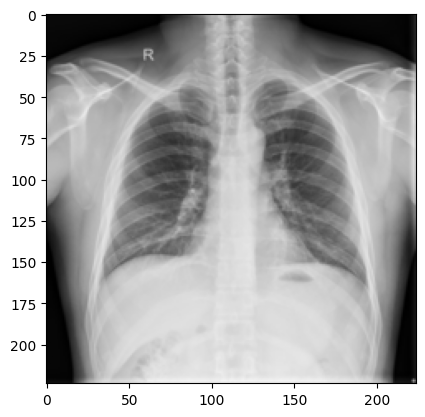

In [ ]:
# Confirmation if our custom dataset pipeline is working

train_td = CustomDataset('train')

print(f'Train set length: {len(train_td)}')

import matplotlib.pyplot as plt

plt.imshow(train_td[0][0].permute(1, 2, 0));

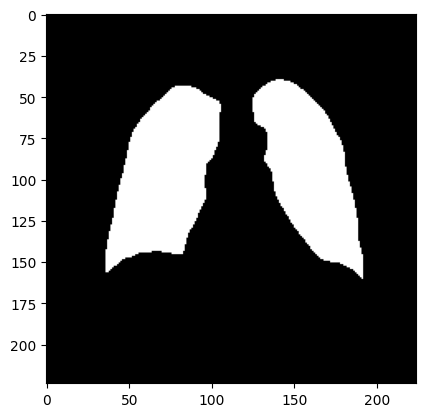

In [ ]:
plt.imshow(train_td[0][1], cmap = 'gray');

In [ ]:
test_td = CustomDataset('test')
val_td = CustomDataset('val')

print(len(train_td))
print(len(test_td))
print(len(val_td))

563
70
71


### Training Loop

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def train_segmentation_model(model, train_data_loader, val_data_loader, optimizer, loss_fn, save_path, epochs=30, device='cpu'):

    model.to(device)

    history = {'Training': {'Loss': [], 'Pixel Accuracy': []},
               'Validation': {'Loss': [], 'Pixel Accuracy': []}}

    best_val_loss = np.inf

    for epoch in range(1, epochs + 1):

        # --- TRAIN ---
        model.train()
        train_loss = 0
        correct_pixels_train = 0
        total_pixels_train = 0

        for batch, target in train_data_loader:
            input = batch.to(device)
            target = target.to(device)

            output = model(input)
            #outputs are logits

            # Output: (B, Num_Classes, H, W), Target: (B, H, W)
            loss = loss_fn(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Pixel-wise Accuracy
            # argmax along channel dimension (dim=1) gives the predicted class map
            predicted_mask = output.argmax(dim=1)
            correct_pixels_train += (predicted_mask == target).sum().item()
            total_pixels_train += target.numel() # Count total pixels in the batch #???

        train_loss /= len(train_data_loader)
        # Divide correct pixels by TOTAL pixels, not total images
        train_acc = correct_pixels_train / total_pixels_train

        history['Training']['Loss'].append(train_loss)
        history['Training']['Pixel Accuracy'].append(train_acc)

        # --- EVALUATE ---
        model.eval()
        val_loss = 0
        correct_pixels_val = 0
        total_pixels_val = 0

        with torch.no_grad():
            for batch, target in val_data_loader:
                input = batch.to(device)
                target = target.to(device).long()

                output = model(input)
                loss = loss_fn(output, target)

                val_loss += loss.item()

                predicted_mask = output.argmax(dim=1)
                correct_pixels_val += (predicted_mask == target).sum().item()
                total_pixels_val += target.numel()

        val_loss /= len(val_data_loader)
        val_acc = correct_pixels_val / total_pixels_val

        history['Validation']['Loss'].append(val_loss)
        history['Validation']['Pixel Accuracy'].append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path) # It's generally better to save state_dict
            print(f"Saved model at epoch {epoch} with Val Loss: {val_loss:.4f}")

        print(f"Epoch: [{epoch}/{epochs}]\t Train Loss: {train_loss:.4f}\t Val Loss: {val_loss:.4f}\t Val Pixel Acc: {val_acc:.4f}")

    return history

## Model definition (Custom CNN)

The inspiration behind this architecture was the deep learning book by Francois

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # --- Encoder ---
        # Block 1: 64 filters. result is 100*100*64 (for 200*200 image)
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)

        # stride is 1, so output dim is maintained at 100*100*64
        self.enc_conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        # Block 2: 128 filters. Output is 50*50*128
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        # output is 50*50*128
        self.enc_conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        # output is 25*25*256
        # Block 3: 256 filters
        self.enc_conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        # output is 25*25*256
        self.enc_conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # --- Decoder ---
        # we replicate the parameters in the last conv layer. no changes in output
        # Block 4: 256 filters
        self.dec_trans1 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1)


        # we replicate conv5. stride of 2 means we upsample to 50*50*256
        # Note: output_padding=1 is required to double the size exactly (e.g., 25->50)
        self.dec_trans2 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1)

        # replicate conv4. no changes. 50*50*256
        # Block 5: 128 filters
        self.dec_trans3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)

        # 100*100*128
        self.dec_trans4 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)


        # 100*100*64
        # Block 6: 64 filters
        self.dec_trans5 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)

        #200*200*64
        self.dec_trans6 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)

        #200*200*3
        # --- Output ---
        self.out_conv = nn.Conv2d(64, num_classes, kernel_size=3, stride=1, padding=1)

    def forward(self, x):

        # Encoder Pass
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = F.relu(self.enc_conv4(x))
        x = F.relu(self.enc_conv5(x))
        x = F.relu(self.enc_conv6(x))

        # Decoder Pass
        x = F.relu(self.dec_trans1(x))
        x = F.relu(self.dec_trans2(x))
        x = F.relu(self.dec_trans3(x))
        x = F.relu(self.dec_trans4(x))
        x = F.relu(self.dec_trans5(x))
        x = F.relu(self.dec_trans6(x))

        # Output
        x = self.out_conv(x)

        return x

In [ ]:
import os
os.cpu_count()

12

## Training run

In [ ]:
from torch.utils.data import DataLoader
from torch import optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SegmentationModel(num_classes=2)

train_td = CustomDataset('train')
val_td = CustomDataset('val')
test_td = CustomDataset('test')

train_dl = DataLoader(train_td, batch_size=64, num_workers= 4, pin_memory = True,
                      persistent_workers=True, shuffle=True)

val_dl = DataLoader(val_td, batch_size=128, num_workers= 4, pin_memory = True,
                      persistent_workers=True)

test_dl = DataLoader(test_td, batch_size=128)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
save_path = 'best_seg.pth'

history = train_segmentation_model(model, train_dl, val_dl, optimizer, loss_fn, save_path, epochs=25, device='cpu')

Saved model at epoch 1 with Val Loss: 0.6789
Epoch: [1/25]	 Train Loss: 0.6932	 Val Loss: 0.6789	 Val Pixel Acc: 0.7509
Saved model at epoch 2 with Val Loss: 0.6752
Epoch: [2/25]	 Train Loss: 0.6499	 Val Loss: 0.6752	 Val Pixel Acc: 0.7529
Saved model at epoch 3 with Val Loss: 0.5567
Epoch: [3/25]	 Train Loss: 0.6371	 Val Loss: 0.5567	 Val Pixel Acc: 0.7529
Epoch: [4/25]	 Train Loss: 0.5292	 Val Loss: 2.5775	 Val Pixel Acc: 0.7529
Epoch: [5/25]	 Train Loss: 0.4591	 Val Loss: 1.5862	 Val Pixel Acc: 0.7529
Epoch: [6/25]	 Train Loss: 0.4336	 Val Loss: 1.9437	 Val Pixel Acc: 0.7529
Epoch: [7/25]	 Train Loss: 0.3860	 Val Loss: 1.6323	 Val Pixel Acc: 0.7529
Epoch: [8/25]	 Train Loss: 0.3595	 Val Loss: 3.5441	 Val Pixel Acc: 0.7529
Epoch: [9/25]	 Train Loss: 0.3022	 Val Loss: 4.7319	 Val Pixel Acc: 0.7529
Epoch: [10/25]	 Train Loss: 0.2882	 Val Loss: 5.4117	 Val Pixel Acc: 0.7529
Epoch: [11/25]	 Train Loss: 0.2726	 Val Loss: 4.7555	 Val Pixel Acc: 0.7581
Epoch: [12/25]	 Train Loss: 0.2018	 Va

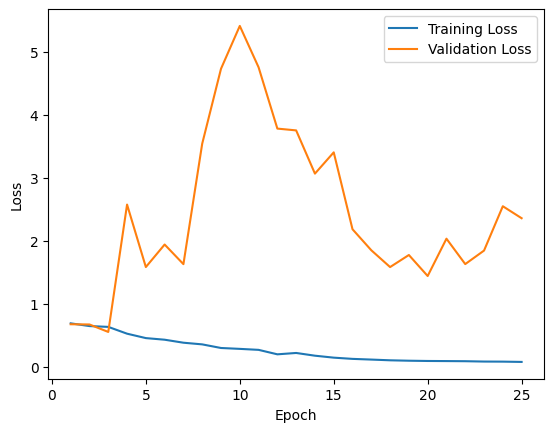

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, len(history['Training']['Loss']) + 1)
plt.plot(x, history['Training']['Loss'], label='Training Loss')
plt.plot(x, history['Validation']['Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

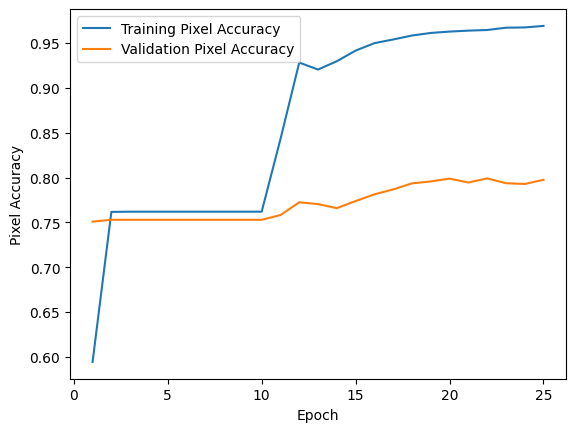

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, len(history['Training']['Pixel Accuracy']) + 1)
plt.plot(x, history['Training']['Pixel Accuracy'], label='Training Pixel Accuracy')
plt.plot(x, history['Validation']['Pixel Accuracy'], label='Validation Pixel Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.legend()
plt.show();

## Load model for prediction

In [ ]:
model = SegmentationModel(num_classes=2)

model_dic = torch.load('best_seg.pth') #load the model's saved state dictionary
model.load_state_dict(model_dic)

model.to(device)

SegmentationModel(
  (enc_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec_trans1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec_trans2): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_trans3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec_trans4): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_trans5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1,

In [ ]:
# predicting the mask for an image

img = test_td[0][0]
mask = test_td[0][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 200, 200
output_mask = model(img.unsqueeze(0).to(device))

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

In [ ]:
pred_mask.shape

torch.Size([224, 224])

In [ ]:
pred_mask.unique()

tensor([0])

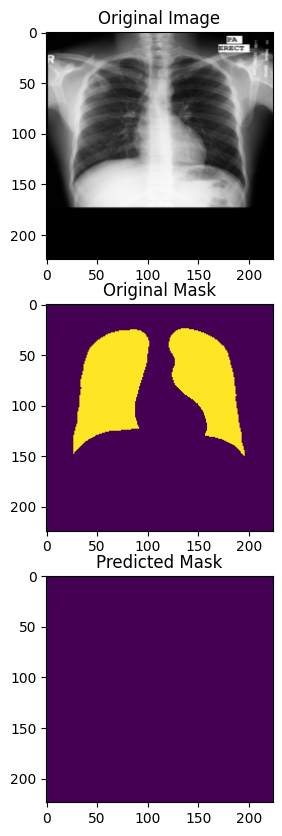

In [ ]:
# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

## Test set prediction

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def predict_segmentation(load_path, test_data_loader, num_classes, device='cpu'):
    """
    Predicts segmentation masks using a trained model.

    Args:
        load_path (str): Path to the saved model state dictionary.
        test_data_loader (DataLoader): DataLoader for the test set.
        img_size (tuple): Size of the input images (H, W).
        num_classes (int): Number of classes for segmentation.
        device (str): Device to run prediction on ('cpu' or 'cuda').

    Returns:
        tuple: (all_predictions, all_targets, accuracy)
            - all_predictions: List or Tensor of predicted masks.
            - all_targets: List or Tensor of ground truth masks.
            - accuracy: Pixel-wise accuracy on the test set.
    """

    # 1. Instantiate the model architecture
    # We need to recreate the model structure before loading weights
    # model = get_model(img_size=img_size, num_classes=num_classes)

    # 2. Load the state dictionary
    # Use map_location to handle loading GPU weights on CPU if needed
    state_dict = torch.load(load_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()

    correct_pixels = 0
    total_pixels = 0

    # We'll store results in CPU lists to avoid GPU OOM for large datasets
    all_predictions = []
    all_targets = []

    print("Starting prediction...")

    with torch.no_grad():
        for batch, targets in test_data_loader:
            inputs = batch.to(device)
            targets = targets.to(device).long()

            # Handle channel dimension in target if present (B, 1, H, W) -> (B, H, W)
            if targets.dim() == 4:
                targets = targets.squeeze(1)

            # Forward pass
            # Output shape: (Batch, Num_Classes, Height, Width)
            output = model(inputs)

            # Get predicted class indices: (Batch, Height, Width)
            preds = output.argmax(dim=1)

            # Calculate batch statistics
            correct_pixels += (preds == targets).sum().item()
            total_pixels += targets.numel()

            # Store results
            # Move to CPU to save GPU memory
            all_predictions.append(preds.cpu())
            all_targets.append(targets.cpu())

    # Calculate global pixel accuracy
    accuracy = correct_pixels / total_pixels
    print(f'Test set pixel accuracy: {accuracy:.4f}')

    # Concatenate all batches into single tensors
    # Final shapes: (Total_Samples, Height, Width)
    combo_predictions = torch.cat(all_predictions, dim=0)
    combo_targets = torch.cat(all_targets, dim=0)

    return combo_predictions, combo_targets, accuracy

# Example Usage (commented out)
if __name__ == "__main__":

    preds, targets, acc = predict_segmentation(
        load_path="best_seg.pth",
        test_data_loader=test_dl,
        num_classes=2,
        device="cuda"
    )

Starting prediction...
Test set pixel accuracy: 0.7652


## Investigate Class Imbalance

Generated using AI.
Class imbalance is the reason the model seems to be decent, but predicts dark pixels only

In [ ]:
import numpy as np

# Assuming train_td is your training dataset (CustomDataset object)
# and masks are available via train_td[idx][1]

class_counts = {0: 0, 1: 0} # Initialize counts for class 0 and class 1
total_pixels = 0

print("Calculating class distribution in training masks...")

for i in range(len(train_td)):
    mask = train_td[i][1] # Get the mask tensor
    unique_values, counts = mask.unique(return_counts=True)

    for val, count in zip(unique_values.tolist(), counts.tolist()):
        if val in class_counts:
            class_counts[val] += count
        total_pixels += count

print(f"Class counts: {class_counts}")

if total_pixels > 0:
    for cls, count in class_counts.items():
        proportion = count / total_pixels
        print(f"Class {cls}: {proportion:.4f} ({(proportion * 100):.2f}%)")
else:
    print("No pixels found in masks to calculate proportion.")


Calculating class distribution in training masks...
Class counts: {0: 21523195, 1: 6725893}
Class 0: 0.7619 (76.19%)
Class 1: 0.2381 (23.81%)
